# **Notebook 01 — Data Extraction and Preprocessing (Sampling & Feature Engineering)**

## Predictive Archaeological Modelling — Peru
**Supervised classification of archaeological site probability using geospatial covariates**

**Author:** Yishar Piero Nieto Barrientos

---

### Objective

This notebook implements the **feature engineering** pipeline that transforms continuous geospatial layers (rasters) into a structured tabular dataset suitable for supervised learning algorithms.

Through **pixel drilling** (point-based multivariate sampling), predictor values are extracted at known archaeological locations and at randomly generated pseudo-absence coordinates.

### Technical Specifications

| Parameter | Value |
|---|---|
| Spatial resolution | 30 × 30 m per pixel |
| Coordinate Reference System | ESRI:102033 (South America Albers Equal Area Conic) |
| DEM source | ASTER GDEM v3 |
| Predictor domains | Topography, Hydrography, Cultural networks |

### **1. Environment Setup**

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import rasterio
import fiona

from shapely.geometry import Point
from shapely.prepared import prep
from osgeo import gdal
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")

# Project paths
RASTER_DIR = "../data/processed/rasters"
SAMPLES_DIR = "../data/processed/samples"
FEATURES_DIR = "../data/features"
FIGURES_DIR = "../outputs/figures"
RAW_DIR = "../data/raw/sitiosarqueologicos"

os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print("Environment configured.")

Environment configured.


### **2. Variable Inventory and Data Sources**

Variables were selected based on criteria of habitability, resource access, and archaeological connectivity. All layers were processed at 30 m resolution.

| Domain | Variable ($X_n$) | Technical Description | Archaeological Hypothesis |
| :--- | :--- | :--- | :--- |
| **Topography** | **Slope** | Terrain inclination ($0°$–$90°$). | Flat to semi-flat terrain is preferred for habitation and agriculture. |
| **Topography** | **Ruggedness (TRI)** | Terrain irregularity index. | Less rugged areas facilitate mobility and construction. |
| **Hydrography** | **Dist. Rivers** | Euclidean distance to watercourses (m). | Water access is the fundamental predictor of habitability. |
| **Hydrography** | **Dist. Lakes** | Euclidean distance to lacustrine bodies (m). | Source of aquatic resources and ritual significance. |
| **Road Network** | **Dist. Qhapaq Ñan** | Distance to the main Inca road network (m). | Connectivity increases the probability of administrative settlements. |
| **Context** | **Dist. Declared** | Proximity to registered point sites. | **Clustering:** Higher probability of satellite sites near known locations. |
| **Context** | **Dist. Zone G1** | Proximity to Monumental Nuclei. | Direct influence of major urban/ceremonial centres. |
| **Context** | **Dist. Zone G2** | Proximity to Cultural Landscapes. | Relationship with extensive anthropic modification areas (terraces, canals). |
| **Context** | **Dist. Zone G3** | Proximity to Isolated Evidence. | Spatial continuity of isolated findings. |

All predictor variables have been standardized to a spatial resolution of **30 m** and aligned to the same raster grid.

In [2]:
archivos_raster = {
    "pendiente":            os.path.join(RASTER_DIR, "pendiente.tif"),
    "rugosidad":            os.path.join(RASTER_DIR, "rugosidad.tif"),
    "distancia_rios":       os.path.join(RASTER_DIR, "distancia_rios.tif"),
    "distancia_lagos":      os.path.join(RASTER_DIR, "distancia_lagos.tif"),
    "distancia_qhapaq_nan": os.path.join(RASTER_DIR, "distancia_qhapaq_nan.tif"),
    "distancia_declarados": os.path.join(RASTER_DIR, "distancia_declarados.tif"),
    "distancia_g1":         os.path.join(RASTER_DIR, "distancia_g1.tif"),
    "distancia_g2":         os.path.join(RASTER_DIR, "distancia_g2.tif"),
    "distancia_g3":         os.path.join(RASTER_DIR, "distancia_g3.tif"),
}

print("--- Geospatial Data Inventory ---")
for name, path in archivos_raster.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            res_x, res_y = src.res
            print(f"  [OK] {name:25s} | {res_x:.1f} m | CRS: {src.crs}")
    else:
        print(f"  [!!] {name:25s} | NOT FOUND: {path}")

--- Geospatial Data Inventory ---
  [OK] pendiente                 | 30.0 m | CRS: ESRI:102033
  [OK] rugosidad                 | 30.0 m | CRS: ESRI:102033
  [OK] distancia_rios            | 30.0 m | CRS: ESRI:102033
  [OK] distancia_lagos           | 30.0 m | CRS: ESRI:102033
  [OK] distancia_qhapaq_nan      | 30.0 m | CRS: ESRI:102033
  [OK] distancia_declarados      | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g1              | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g2              | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g3              | 30.0 m | CRS: ESRI:102033


#### **2.1 Terrain Layer Visualization and Validation**
Lightweight raster preview of each terrain variable to confirm structural and spatial integrity before batch processing.

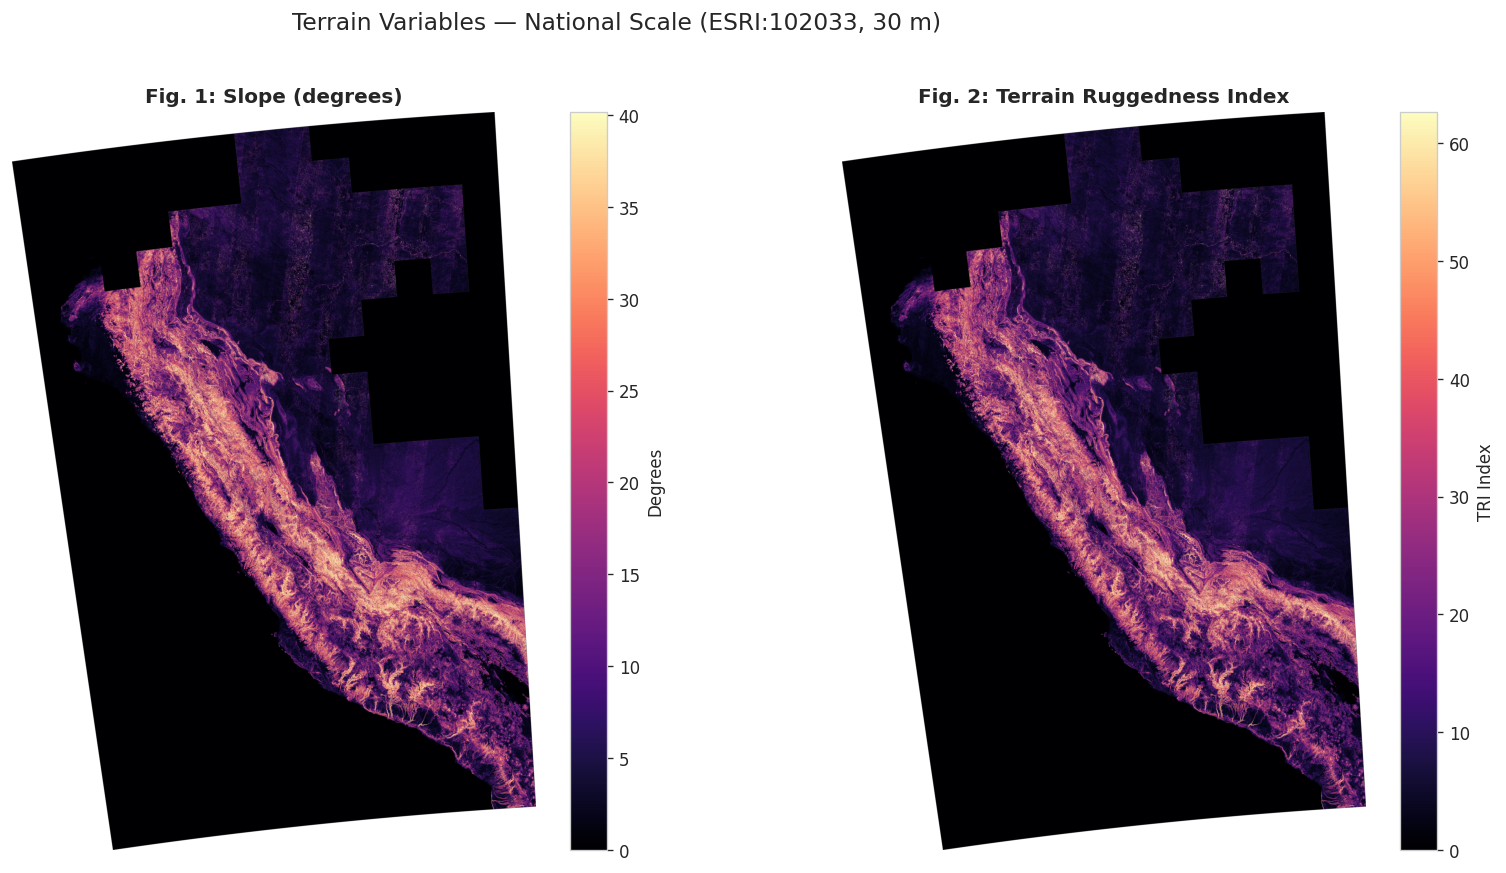

In [3]:
capas_terrain = {
    "Slope (degrees)":           os.path.join(RASTER_DIR, "pendiente.tif"),
    "Terrain Ruggedness Index":  os.path.join(RASTER_DIR, "rugosidad.tif"),
}

fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=120)

for i, (title, path) in enumerate(capas_terrain.items()):
    with rasterio.open(path) as src:
        data = src.read(1, out_shape=(1, src.height // 10, src.width // 10))
        nodata = src.nodata
        data_viz = data.astype("float32")
        if nodata is not None:
            data_viz[data_viz == nodata] = np.nan

        v_min = np.nanpercentile(data_viz, 1)
        v_max = np.nanpercentile(data_viz, 99)

        im = axes[i].imshow(data_viz, cmap="magma", vmin=v_min, vmax=v_max)
        cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        cbar.set_label("Degrees" if i == 0 else "TRI Index")
        axes[i].set_title(f"Fig. {i + 1}: {title}", fontsize=12, fontweight="bold")
        axes[i].axis("off")

fig.suptitle("Terrain Variables — National Scale (ESRI:102033, 30 m)", fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_terrain_variables.png"), dpi=150, bbox_inches="tight")
plt.show()

#### **2.2 Distance Layer Visualization and Validation**
Euclidean distances to hydrological and cultural features. The Viridis gradient displays proximity: dark tones indicate immediate nearness, facilitating identification of high-connectivity zones.

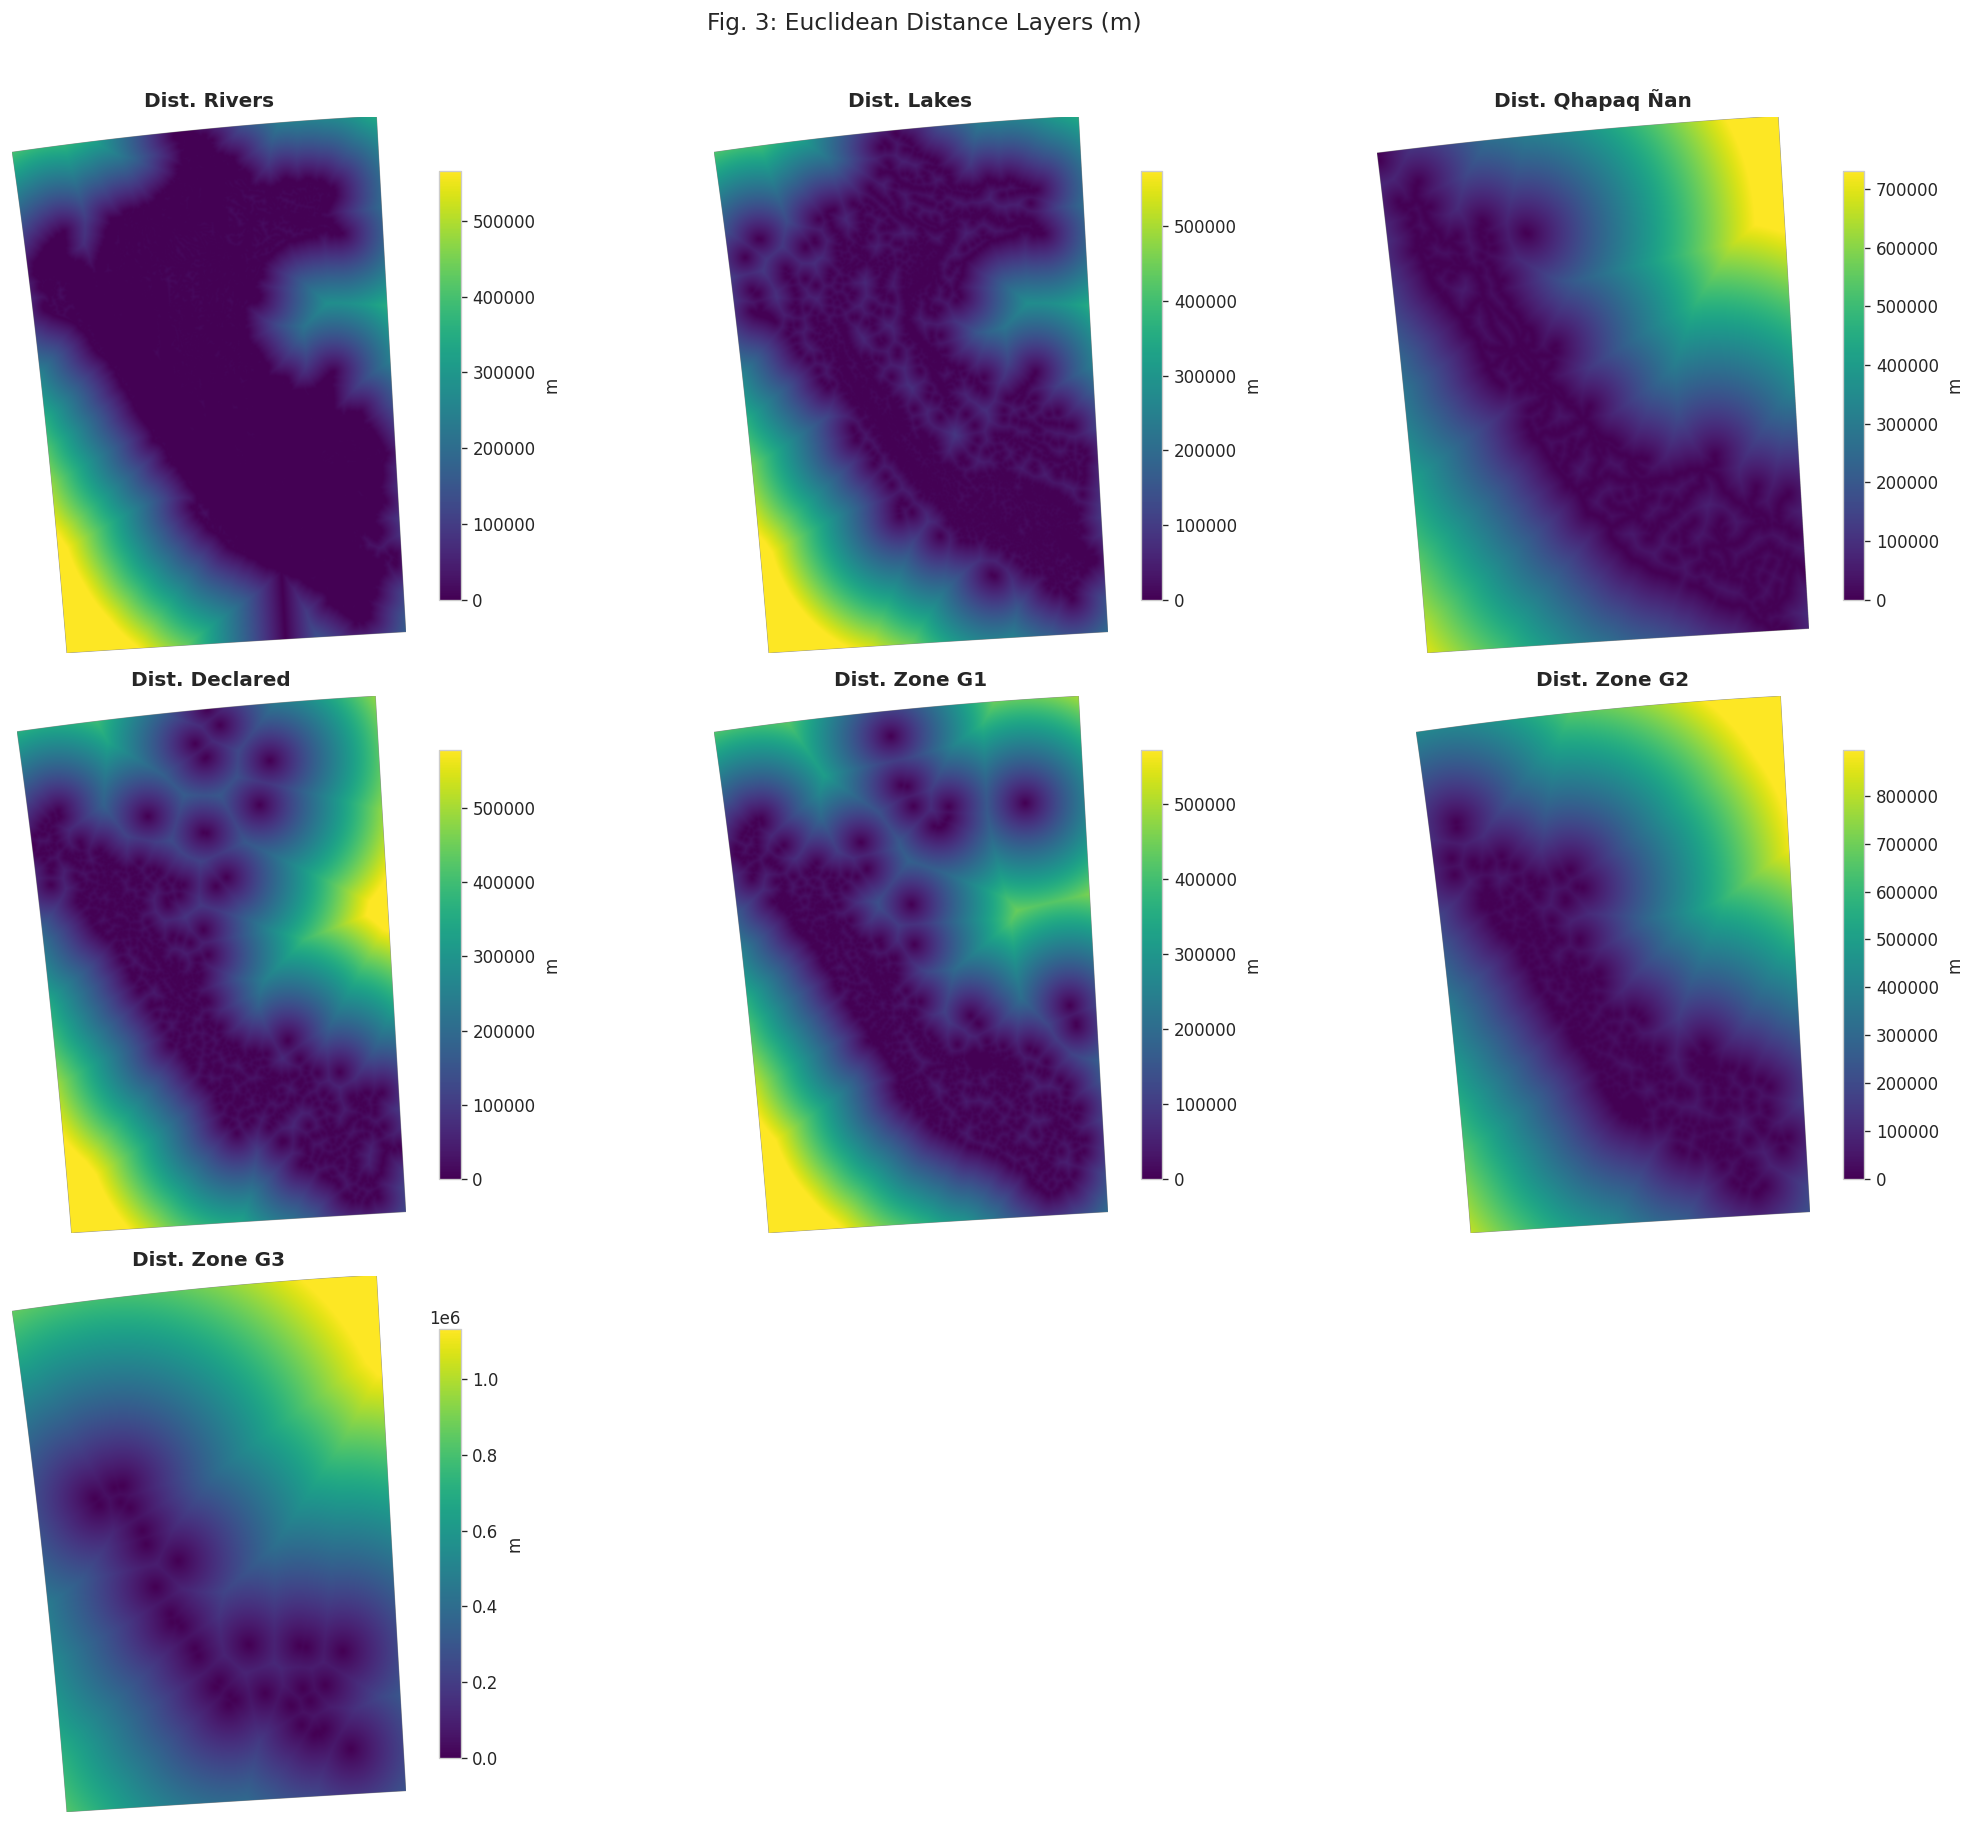

In [4]:
capas_distancia = {
    "Rivers":      os.path.join(RASTER_DIR, "distancia_rios.tif"),
    "Lakes":       os.path.join(RASTER_DIR, "distancia_lagos.tif"),
    "Qhapaq Ñan": os.path.join(RASTER_DIR, "distancia_qhapaq_nan.tif"),
    "Declared":    os.path.join(RASTER_DIR, "distancia_declarados.tif"),
    "Zone G1":     os.path.join(RASTER_DIR, "distancia_g1.tif"),
    "Zone G2":     os.path.join(RASTER_DIR, "distancia_g2.tif"),
    "Zone G3":     os.path.join(RASTER_DIR, "distancia_g3.tif"),
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15), dpi=120)
axes = axes.flatten()

for i, (label, path) in enumerate(capas_distancia.items()):
    with rasterio.open(path) as src:
        data = src.read(1, out_shape=(1, src.height // 10, src.width // 10))
        data = np.where(data == src.nodata, np.nan, data)
        v_max = np.nanpercentile(data, 98)

        im = axes[i].imshow(data, cmap="viridis", vmax=v_max)
        fig.colorbar(im, ax=axes[i], label="m", shrink=0.8)
        axes[i].set_title(f"Dist. {label}", fontweight="bold")
        axes[i].axis("off")

for j in range(len(capas_distancia), len(axes)):
    axes[j].axis("off")

fig.suptitle("Fig. 3: Euclidean Distance Layers (m)", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_distance_layers.png"), dpi=150, bbox_inches="tight")
plt.show()

### **3. Dependent Variable Sampling ($Y = 1$: Presences)**

The positive class (Archaeological Presence) is constructed by integrating point records and inverse-vectorized zonation surfaces. To handle spatial imbalance between large monumental complexes and isolated finds, a **stratified random sampling** protocol is applied:

1. **Hybrid data source:**
    * **Declared Sites (Points):** All registered centroids ($N_{\text{total}}$).
    * **Delimited Areas (Zones G1, G2, G3):** Pixels with value $= 0$ in Euclidean distance rasters, representing the interior of original delimitation polygons.

2. **Quota Sampling:**
    To mitigate *area bias* (where extensive sites like Chan Chan could dominate the training sample), maximum extraction quotas are set per category:
    * **Zone G1 (Monumental):** Dense sampling (limit: 5,000 random pixels).
    * **Zone G2 (Cultural Landscape):** Medium sampling (limit: 3,000 pixels).
    * **Zone G3 (Isolated Evidence):** Targeted sampling (limit: 1,000 pixels).

3. **Spatial Validation:**
    All extracted coordinates are snapped to the 30 m grid and spatially deduplicated, ensuring each observation corresponds to a unique minimum analysis unit.

In [5]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
ruta_puntos_shp = os.path.join(RAW_DIR, "declarados", "declarados.shp")

rasters_zonas = {
    "G1": os.path.join(RASTER_DIR, "distancia_g1.tif"),
    "G2": os.path.join(RASTER_DIR, "distancia_g2.tif"),
    "G3": os.path.join(RASTER_DIR, "distancia_g3.tif"),
}

cuotas_muestreo = {"G1": 5000, "G2": 3000, "G3": 1000}
lista_dataframes = []

# ==============================================================================
# 2. DECLARED SITES (POINT SHAPEFILE)
# ==============================================================================
print("--- Step 1: Processing declared sites (SHP) ---")
if os.path.exists(ruta_puntos_shp):
    gdf = gpd.read_file(ruta_puntos_shp)
    if gdf.crs != "ESRI:102033":
        gdf = gdf.to_crs("ESRI:102033")

    df_pt = pd.DataFrame({
        "X_102033": gdf.geometry.x,
        "Y_102033": gdf.geometry.y,
        "Origen": "Sitio_Declarado",
        "Target": 1,
    })
    lista_dataframes.append(df_pt)
    print(f"  Added {len(df_pt)} declared sites.")
else:
    print(f"  WARNING: Not found: {ruta_puntos_shp}")

# ==============================================================================
# 3. ZONE EXTRACTION FROM DISTANCE RASTERS
# ==============================================================================
print("\n--- Step 2: Extracting zone pixels from distance rasters ---")

for zona, ruta in rasters_zonas.items():
    if not os.path.exists(ruta):
        print(f"  [SKIP] {zona}: file not found.")
        continue

    print(f"  Scanning {zona} ...")
    coord_temp = []

    with rasterio.open(ruta) as src:
        for ji, window in tqdm(list(src.block_windows(1)), desc=f"  {zona}"):
            data = src.read(1, window=window)
            mask = (data >= 0) & (data < 1.0)
            if np.any(mask):
                rows, cols = np.where(mask)
                xs, ys = src.xy(rows + window.row_off, cols + window.col_off)
                coord_temp.extend(list(zip(xs, ys)))

    total = len(coord_temp)
    cuota = cuotas_muestreo.get(zona, 1000)

    df_zona = pd.DataFrame(coord_temp, columns=["X_102033", "Y_102033"])
    if total > cuota:
        df_zona = df_zona.sample(n=cuota, random_state=42)
        print(f"  {zona}: {total} pixels found -> sampled to {cuota}")
    else:
        print(f"  {zona}: {total} pixels found -> kept all")

    df_zona["Origen"] = f"Zona_{zona}"
    df_zona["Target"] = 1
    lista_dataframes.append(df_zona)

# ==============================================================================
# 4. MERGE AND SPATIAL DEDUPLICATION
# ==============================================================================
print("\n--- Step 3: Merging and deduplicating ---")
if lista_dataframes:
    df_final = pd.concat(lista_dataframes, ignore_index=True)

    df_final["x_snap"] = (df_final["X_102033"] // 30) * 30
    df_final["y_snap"] = (df_final["Y_102033"] // 30) * 30

    n_before = len(df_final)
    df_final = df_final.drop_duplicates(subset=["x_snap", "y_snap"])
    n_after = len(df_final)

    df_export = df_final[["X_102033", "Y_102033", "Origen", "Target"]]

    ruta_salida = os.path.join(SAMPLES_DIR, "presencias.csv")
    df_export.to_csv(ruta_salida, index=False)

    print(f"  Before dedup: {n_before} | After: {n_after}")
    print(f"  Saved: {ruta_salida}")
    print(f"\n  Distribution by origin:")
    print(df_export["Origen"].value_counts().to_string())
else:
    print("  ERROR: No data generated.")

--- Step 1: Processing declared sites (SHP) ---
  Added 5890 declared sites.

--- Step 2: Extracting zone pixels from distance rasters ---
  Scanning G1 ...


  G1: 100%|██████████| 73649/73649 [01:26<00:00, 849.29it/s] 


  G1: 8274226 pixels found -> sampled to 5000
  Scanning G2 ...


  G2: 100%|██████████| 73649/73649 [01:25<00:00, 863.30it/s] 


  G2: 11851141 pixels found -> sampled to 3000
  Scanning G3 ...


  G3: 100%|██████████| 73649/73649 [01:05<00:00, 1132.43it/s]


  G3: 1318 pixels found -> sampled to 1000

--- Step 3: Merging and deduplicating ---
  Before dedup: 14890 | After: 14786
  Saved: ../data/processed/samples/presencias.csv

  Distribution by origin:
Origen
Sitio_Declarado    5786
Zona_G1            5000
Zona_G2            3000
Zona_G3            1000


### **4. Background Data Generation (Pseudo-absences, $Y = 0$)**

To mitigate the inherent bias of *Presence-Only* records, **pseudo-absences** are generated via uniform spatial random sampling within the national boundary.

1. **Sampling frame:** Peru's official administrative boundary projected to ESRI:102033.
2. **Generation algorithm (Target Shooting):** Random coordinates $(x, y)$ drawn from a uniform distribution within the bounding box, validated in two stages:
    * **Geometric validation:** Only points strictly inside Peru's polygon are retained.
    * **Exclusion filter:** Points coinciding spatially (on the 30 × 30 m grid) with confirmed archaeological sites ($Y=1$) are discarded, ensuring class independence.
3. **Class balance:** The iterative process stops upon reaching a **1:1 ratio** with respect to the presence set ($N_{\text{absences}} = N_{\text{presences}}$).

In [6]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
ruta_presencias = os.path.join(SAMPLES_DIR, "presencias.csv")
ruta_mask = os.path.join(RASTER_DIR, "pendiente.tif")

if not os.path.exists(ruta_mask):
    raise FileNotFoundError(f"Mask raster not found: {ruta_mask}")

print("--- 1. Loading presence data ---")
df_si = pd.read_csv(ruta_presencias)
n_objetivo = len(df_si)
print(f"  Target: {n_objetivo} pseudo-absence points (1:1 ratio).")

# Blacklist set (snapped to 30 m grid)
set_presencias = set(zip(
    (pd.to_numeric(df_si["X_102033"], errors="coerce") // 30).fillna(0).astype(int) * 30,
    (pd.to_numeric(df_si["Y_102033"], errors="coerce") // 30).fillna(0).astype(int) * 30,
))

# ==============================================================================
# 2. LOAD PERU BOUNDARY
# ==============================================================================
print("--- 2. Loading country boundary ---")
url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url_mapa)
peru_gdf = world[world["ADMIN"] == "Peru"].to_crs("ESRI:102033")
peru_geom = peru_gdf.geometry.values[0]
peru_optimizado = prep(peru_geom)

minx, miny, maxx, maxy = peru_gdf.total_bounds

# ==============================================================================
# 3. RANDOM SPATIAL SAMPLING (Target Shooting)
# ==============================================================================
ausencias_validas = []
batch_size = 50000
pbar = tqdm(total=n_objetivo, desc="  Generating")

print("--- 3. Generating pseudo-absence coordinates ---")

with rasterio.open(ruta_mask) as src:
    while len(ausencias_validas) < n_objetivo:
        x_rand = np.random.uniform(minx, maxx, batch_size)
        y_rand = np.random.uniform(miny, maxy, batch_size)

        candidatos = []
        coords_to_sample = list(zip(x_rand, y_rand))
        for (x, y), val in zip(coords_to_sample, src.sample(coords_to_sample)):
            if val[0] != src.nodata:
                candidatos.append((x, y))

        for x, y in candidatos:
            if len(ausencias_validas) >= n_objetivo:
                break
            if peru_optimizado.contains(Point(x, y)):
                x_grid = int(x // 30) * 30
                y_grid = int(y // 30) * 30
                if (x_grid, y_grid) not in set_presencias:
                    ausencias_validas.append({"X_102033": x, "Y_102033": y})
                    pbar.update(1)

pbar.close()

# ==============================================================================
# 4. SAVE
# ==============================================================================
df_out = pd.DataFrame(ausencias_validas)
df_out["Origen"] = "Pseudo_Ausencia"
df_out["Target"] = 0

ruta_salida = os.path.join(SAMPLES_DIR, "ausencias.csv")
df_out.to_csv(ruta_salida, index=False)

print(f"\n  Generated {len(df_out)} pseudo-absence points.")
print(f"  Saved: {ruta_salida}")

--- 1. Loading presence data ---
  Target: 14786 pseudo-absence points (1:1 ratio).
--- 2. Loading country boundary ---


  Generating:   0%|          | 0/14786 [00:00<?, ?it/s]

--- 3. Generating pseudo-absence coordinates ---


  Generating: 100%|██████████| 14786/14786 [01:28<00:00, 167.91it/s]


  Generated 14786 pseudo-absence points.
  Saved: ../data/processed/samples/ausencias.csv


### **5. Spatial Distribution Map**

Spatial distribution of training samples. Red points ($Y=1$) represent positive archaeological evidence (declared sites and zone-sampled pixels). Blue points ($Y=0$) represent pseudo-absences generated uniformly within Peru's national boundary, excluding known archaeological zones. Orange polygons indicate officially delimited archaeological areas.

Preparing spatial visualization ...


/tmp/ipykernel_7223/2980687764.py:58: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  leg = ax.legend(loc="lower left", frameon=True, fontsize=11, markerscale=6)


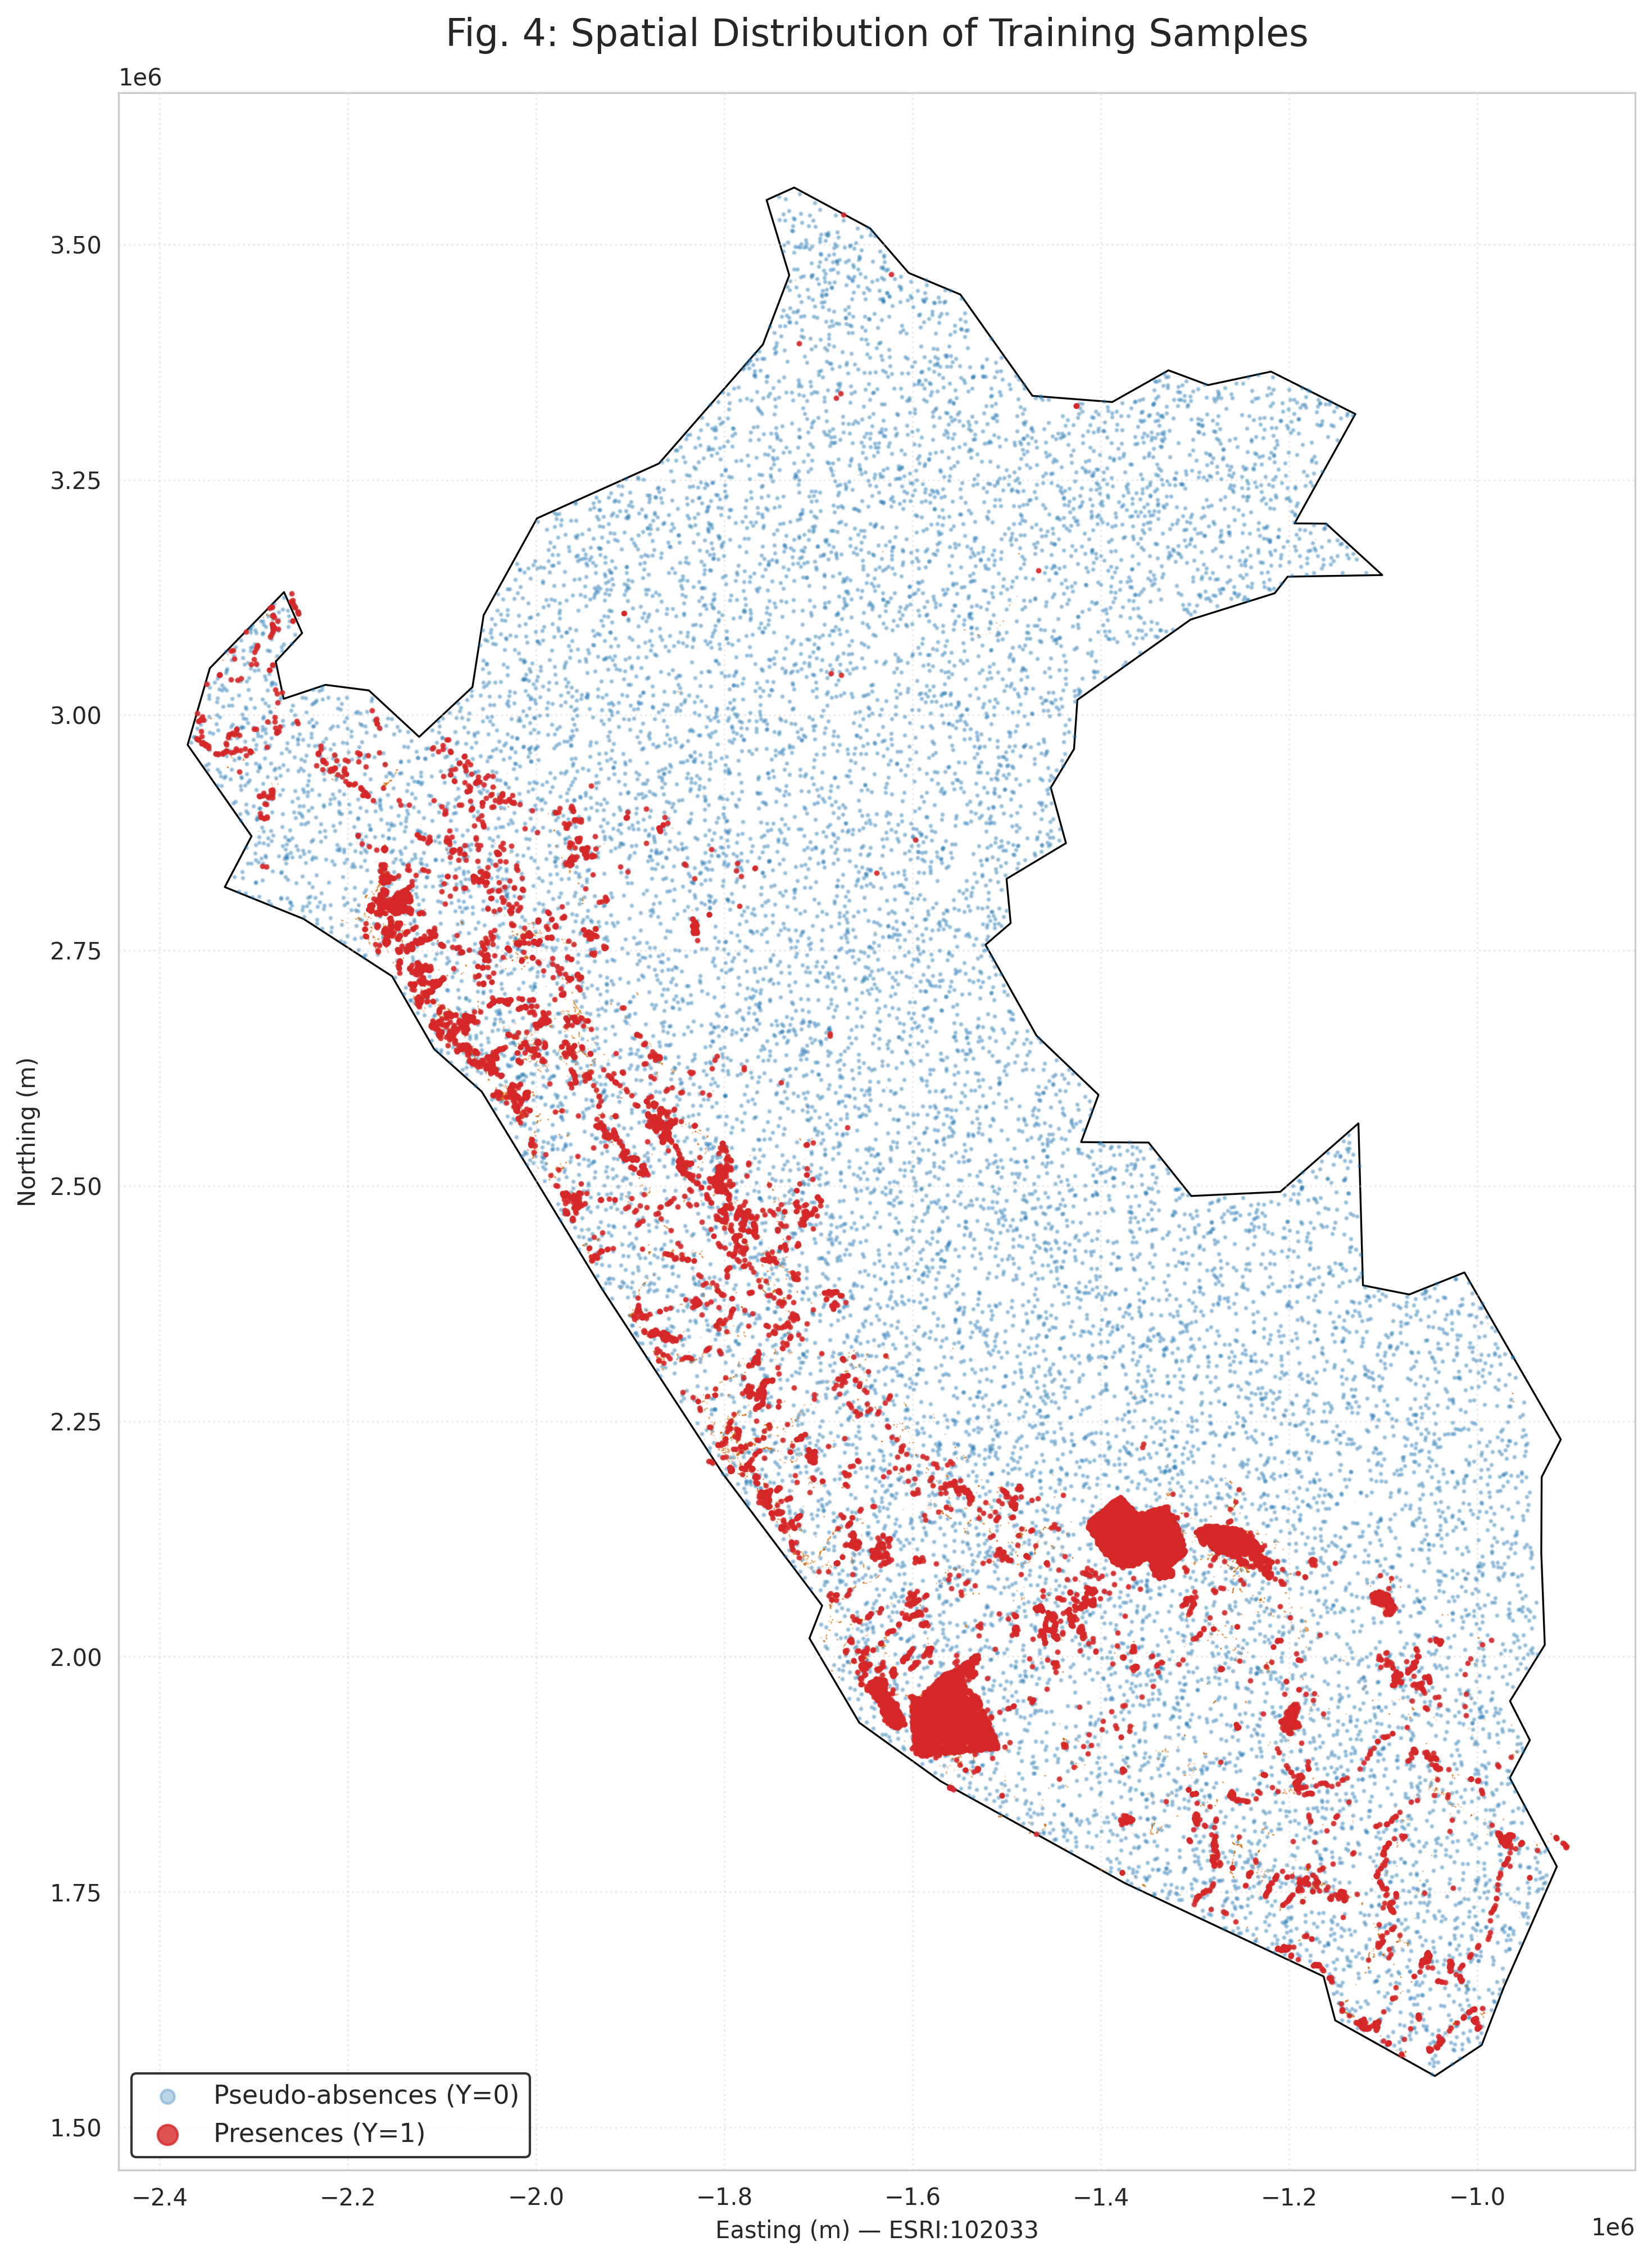

Figure saved: ../outputs/figures/fig_training_distribution.png


In [7]:
# ==============================================================================
# 1. LOAD DATA
# ==============================================================================
ruta_delimitados = os.path.join(RAW_DIR, "delimitados", "delimitados.shp")
ruta_si = os.path.join(SAMPLES_DIR, "presencias.csv")
ruta_no = os.path.join(SAMPLES_DIR, "ausencias.csv")

print("Preparing spatial visualization ...")

df_si = pd.read_csv(ruta_si)
df_no = pd.read_csv(ruta_no)

gdf_si = gpd.GeoDataFrame(
    df_si, geometry=gpd.points_from_xy(df_si.X_102033, df_si.Y_102033), crs="ESRI:102033"
)
gdf_no = gpd.GeoDataFrame(
    df_no, geometry=gpd.points_from_xy(df_no.X_102033, df_no.Y_102033), crs="ESRI:102033"
)

gdf_delimitados = None
if os.path.exists(ruta_delimitados):
    gdf_delimitados = gpd.read_file(ruta_delimitados)
    if gdf_delimitados.crs != "ESRI:102033":
        gdf_delimitados = gdf_delimitados.to_crs("ESRI:102033")

# Peru border
try:
    url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url_mapa)
    peru_borde = world[world["ADMIN"] == "Peru"].to_crs("ESRI:102033")
except Exception:
    peru_borde = None

# ==============================================================================
# 2. PLOT
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 16), dpi=300)

if peru_borde is not None:
    peru_borde.plot(ax=ax, color="white", edgecolor="black", linewidth=0.8, zorder=0)

if gdf_delimitados is not None:
    gdf_delimitados.plot(
        ax=ax, color="#ff7f0e", edgecolor="#cc6600",
        linewidth=0.5, alpha=0.5,
        label="Delimited zones (polygons)", zorder=2,
    )

gdf_no.plot(ax=ax, markersize=1, color="#1f77b4", alpha=0.3,
            label="Pseudo-absences (Y=0)", zorder=1)
gdf_si.plot(ax=ax, markersize=2, color="#d62728", alpha=0.8,
            label="Presences (Y=1)", zorder=3)

ax.set_title("Fig. 4: Spatial Distribution of Training Samples", fontsize=16, pad=20)
ax.set_xlabel("Easting (m) — ESRI:102033", fontsize=10)
ax.set_ylabel("Northing (m)", fontsize=10)

leg = ax.legend(loc="lower left", frameon=True, fontsize=11, markerscale=6)
leg.get_frame().set_edgecolor("black")
ax.grid(True, linestyle=":", alpha=0.4)
ax.set_aspect("equal")

fig.savefig(os.path.join(FIGURES_DIR, "fig_training_distribution.png"), bbox_inches="tight", dpi=300)
plt.show()
print(f"Figure saved: {FIGURES_DIR}/fig_training_distribution.png")

### **6. Feature Extraction (Pixel Drilling)**

For each sample coordinate, the corresponding pixel value is extracted from every raster layer. Rows with NoData values (out-of-bounds or edge artefacts) are dropped. The resulting tabular dataset is exported to `data/features/dataset_entrenamiento.csv`.

In [8]:
print("--- Pixel Drilling ---")

# ==============================================================================
# 1. LOAD AND MERGE SAMPLES
# ==============================================================================
ruta_si = os.path.join(SAMPLES_DIR, "presencias.csv")
ruta_no = os.path.join(SAMPLES_DIR, "ausencias.csv")

if not (os.path.exists(ruta_si) and os.path.exists(ruta_no)):
    raise FileNotFoundError("Sample CSV files not found. Run previous cells first.")

df_si = pd.read_csv(ruta_si)
df_no = pd.read_csv(ruta_no)
df_master = pd.concat([df_si, df_no], ignore_index=True)

print(f"  Total samples:  {len(df_master)}")
print(f"  Presences (1):  {len(df_si)}")
print(f"  Absences (0):   {len(df_no)}")

# ==============================================================================
# 2. DEFINE RASTER VARIABLES
# ==============================================================================
rasters = {
    "pendiente":   os.path.join(RASTER_DIR, "pendiente.tif"),
    "rugosidad":   os.path.join(RASTER_DIR, "rugosidad.tif"),
    "dist_rios":   os.path.join(RASTER_DIR, "distancia_rios.tif"),
    "dist_lagos":  os.path.join(RASTER_DIR, "distancia_lagos.tif"),
    "dist_qhapaq": os.path.join(RASTER_DIR, "distancia_qhapaq_nan.tif"),
    "dist_g1":     os.path.join(RASTER_DIR, "distancia_g1.tif"),
    "dist_g2":     os.path.join(RASTER_DIR, "distancia_g2.tif"),
    "dist_g3":     os.path.join(RASTER_DIR, "distancia_g3.tif"),
}

for name, path in rasters.items():
    status = "OK" if os.path.exists(path) else "MISSING"
    print(f"  [{status}] {name}")

# ==============================================================================
# 3. EXTRACTION
# ==============================================================================
print("\n  Extracting pixel values ...")
coords = list(zip(df_master["X_102033"], df_master["Y_102033"]))

for var_name, raster_path in rasters.items():
    if os.path.exists(raster_path):
        with rasterio.open(raster_path) as src:
            values = [x[0] for x in src.sample(coords)]
            df_master[var_name] = values
            if src.nodata is not None:
                df_master.loc[df_master[var_name] == src.nodata, var_name] = np.nan
        print(f"  Extracted: {var_name}")
    else:
        df_master[var_name] = np.nan
        print(f"  SKIPPED:   {var_name} (file not found)")

# ==============================================================================
# 4. CLEAN AND SAVE
# ==============================================================================
n_before = len(df_master)
df_final = df_master.dropna()
n_after = len(df_final)

print(f"\n  Rows dropped (NoData / out of bounds): {n_before - n_after}")
print(f"  Final dataset: {n_after} observations")

ruta_salida = os.path.join(FEATURES_DIR, "dataset_entrenamiento.csv")
df_final.to_csv(ruta_salida, index=False)

print(f"  Saved: {ruta_salida}")
print(f"\n  Preview:")
df_final.head()

--- Pixel Drilling ---
  Total samples:  29572
  Presences (1):  14786
  Absences (0):   14786
  [OK] pendiente
  [OK] rugosidad
  [OK] dist_rios
  [OK] dist_lagos
  [OK] dist_qhapaq
  [OK] dist_g1
  [OK] dist_g2
  [OK] dist_g3

  Extracting pixel values ...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: pendiente


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: rugosidad


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_rios


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_lagos


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_qhapaq


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_g1


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_g2


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


  Extracted: dist_g3

  Rows dropped (NoData / out of bounds): 2349
  Final dataset: 27223 observations
  Saved: ../data/features/dataset_entrenamiento.csv

  Preview:


X_102033      Y_102033           Origen  Target  pendiente  rugosidad  \
0 -1.794915e+06  2.428515e+06  Sitio_Declarado       1   2.569503   3.464102   
1 -1.780363e+06  2.414741e+06  Sitio_Declarado       1   4.431820   5.830952   
2 -1.778420e+06  2.414945e+06  Sitio_Declarado       1   4.727942   6.708204   
3 -1.791737e+06  2.426272e+06  Sitio_Declarado       1   3.372287  12.124355   
4 -1.806857e+06  2.438869e+06  Sitio_Declarado       1   5.788832   8.124039   

    dist_rios   dist_lagos  dist_qhapaq       dist_g1      dist_g2  \
0   30.000000  2731.483154    30.000000   1955.760742     0.000000   
1  954.829834    60.000000  1950.230713   2640.000000  1890.952148   
2   84.852814   540.832642     0.000000    630.000000     0.000000   
3   90.000000  2508.007324    30.000000   2502.258789     0.000000   
4  573.149170  1281.600586     0.000000  15218.724609  4797.843262   

        dist_g3  
0  35445.734375  
1  37885.343750  
2  37040.683594  
3  34444.000000  
4  41604.332031